In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from datetime import datetime
# Image manipulation.
import PIL.Image


#loading the test csv
testing_animals = pd.read_csv('animal_dataset_intermediate/Testing_set_animals.csv')
testing_animals.head()

,filename,target
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,NaN
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,NaN
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,NaN
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,NaN
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,NaN


In [23]:
#just checking the predicitons target column
testing_animals.target.unique()

array([nan])

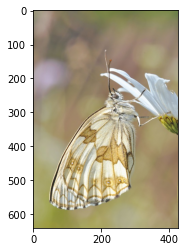

In [24]:
#plotting a test image
filename = testing_animals['filename'][0]

image = PIL.Image.open('animal_dataset_intermediate/test/data/'+filename)


plt.imshow(image)


Found 8196 files belonging to 5 classes.
Using 6557 files for training.


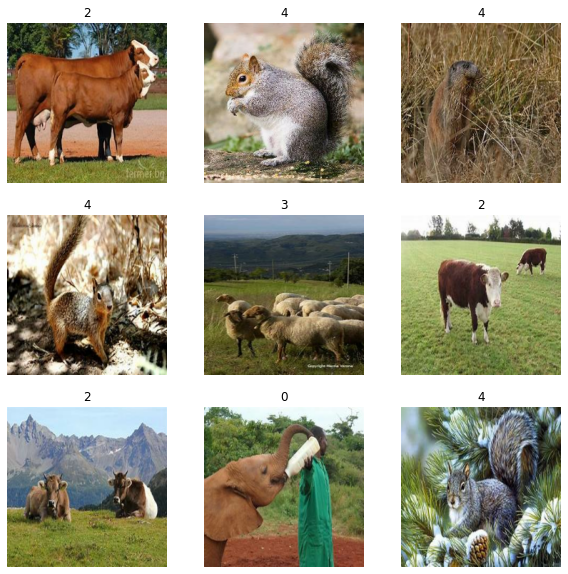

In [25]:
image_size = (224, 224)
batch_size = 32

train_ds = image_dataset_from_directory(
    "animal_dataset_intermediate/train/",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

#visualizing the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")



In [26]:
#creating the train, validation and test data generators
train_datagen = ImageDataGenerator(rescale = 1./255., # rescaling i.e. normalizing the data
                                   rotation_range = 40,  # for augmentation: applying common techniques such as rotation, zoom and flipping
                                   width_shift_range = 0.2,
                                   validation_split = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# create a data generation with the train truth and test images from the directory


train_generator=train_datagen.flow_from_directory(directory="animal_dataset_intermediate/train/",
                                            target_size=(224,224),
                                            color_mode='rgb',
                                            subset="training",
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical")



validation_generator=val_datagen.flow_from_directory(directory="animal_dataset_intermediate/train/",
                                            target_size=(224,224),
                                            color_mode='rgb',
                                            subset="validation",
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical")



test_generator = test_datagen.flow_from_directory(directory="animal_dataset_intermediate/test/",
                                                  target_size=(224, 224),
                                                  color_mode="rgb",
                                                  batch_size=32,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42)

Found 6558 images belonging to 5 classes.
Found 1638 images belonging to 5 classes.
Found 910 images belonging to 1 classes.


In [27]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'MLP_animal_model.h5'

batch_size = 32
steps_per_epoch= 6558/batch_size
num_classes = 5
epochs = 20
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)




mlp = Sequential(name="MLP")
mlp.add(Flatten(input_shape=(224,224, 3),name='flatten'))
mlp.add(Dense(512, activation='relu',name='hidden_1',kernel_regularizer = 'l2'))###using regularizer
mlp.add(Dropout(0.5,name='droupout_1'))
mlp.add(Dense(num_classes, activation='softmax',name='output'))#this the output layer and we use the softmax function since this is a multiclass problem
mlp.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001), metrics=['accuracy'])


In [28]:
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [29]:
mlp.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               77070848  
_________________________________________________________________
droupout_1 (Dropout)         (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 5)                 2565      
Total params: 77,073,413
Trainable params: 77,073,413
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [31]:
history_mlp = mlp.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback,es],
    verbose=1)


Epoch 1/20
  1/204 [..............................] - ETA: 0s - loss: 12.0926 - accuracy: 0.1333WARNING:tensorflow:From c:\users\ricardo_2\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
205/204 [==============================] - 419s 2s/step - loss: 11.7931 - accuracy: 0.2682 - val_loss: 11.6275 - val_accuracy: 0.3199
Epoch 2/20
205/204 [==============================] - 233s 1s/step - loss: 11.6112 - accuracy: 0.3039 - val_loss: 11.5147 - val_accuracy: 0.3498
Epoch 3/20
205/204 [==============================] - 231s 1s/step - loss: 11.5064 - accuracy: 0.3237 - val_loss: 11.4021 - val_accuracy: 0.4133
Epoch 4/20
205/204 [==============================] - 231s 1s/step - loss: 11.4102 - accuracy: 0.3227 - val_loss: 11.2940 - val_accuracy: 0.4139
Epoch 5/20
205/204 [

In [32]:
# Save model
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at c:\DPHi\assignment2\saved_models\MLP_animal_model.h5 


In [35]:
#using the CIFAR-10 as transfer learning

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'CNN_animal_model.h5'

#On Line 1 we learn a total of 32 filters. Max pooling is then used to reduce the spatial dimensions of the output volume.



model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(224,224, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#We then learn 64 filters on Line 4. Again max pooling is used to reduce the spatial dimensions.
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


#using the same architecture as the MLP
model.add(Flatten(name='flatten'))
model.add(Dense(512, activation='relu',name='hidden_1',kernel_regularizer = 'l2'))
model.add(Dropout(0.5,name='droupout_1'))
model.add(Dense(num_classes, activation='softmax',name='output'))



model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [36]:
history_mlp = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback,es],
    verbose=1)


Epoch 1/20
205/204 [==============================] - 2001s 10s/step - loss: 3.1334 - accuracy: 0.3513 - val_loss: 1.4397 - val_accuracy: 0.5128
Epoch 2/20
205/204 [==============================] - 1938s 9s/step - loss: 1.4805 - accuracy: 0.4634 - val_loss: 1.2948 - val_accuracy: 0.5549
Epoch 3/20
205/204 [==============================] - 1937s 9s/step - loss: 1.4068 - accuracy: 0.4838 - val_loss: 1.2925 - val_accuracy: 0.5739
Epoch 4/20
205/204 [==============================] - 1936s 9s/step - loss: 1.3867 - accuracy: 0.5026 - val_loss: 1.2288 - val_accuracy: 0.6026
Epoch 5/20
205/204 [==============================] - 1944s 9s/step - loss: 1.3665 - accuracy: 0.5116 - val_loss: 1.1887 - val_accuracy: 0.6233
Epoch 6/20
205/204 [==============================] - 1914s 9s/step - loss: 1.3414 - accuracy: 0.5297 - val_loss: 1.2159 - val_accuracy: 0.6068
Epoch 7/20
205/204 [==============================] - 1932s 9s/step - loss: 1.3277 - accuracy: 0.5454 - val_loss: 1.1703 - val_accuracy

In [37]:
# Save model
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at c:\DPHi\assignment2\saved_models\CNN_animal_model.h5 


In [39]:
%load_ext tensorboard


In [41]:
#as you can see I get this error while trying to open directly on jupyter but it runs normally on localhost:6006 so I've saved the graph and show it below
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 1164.

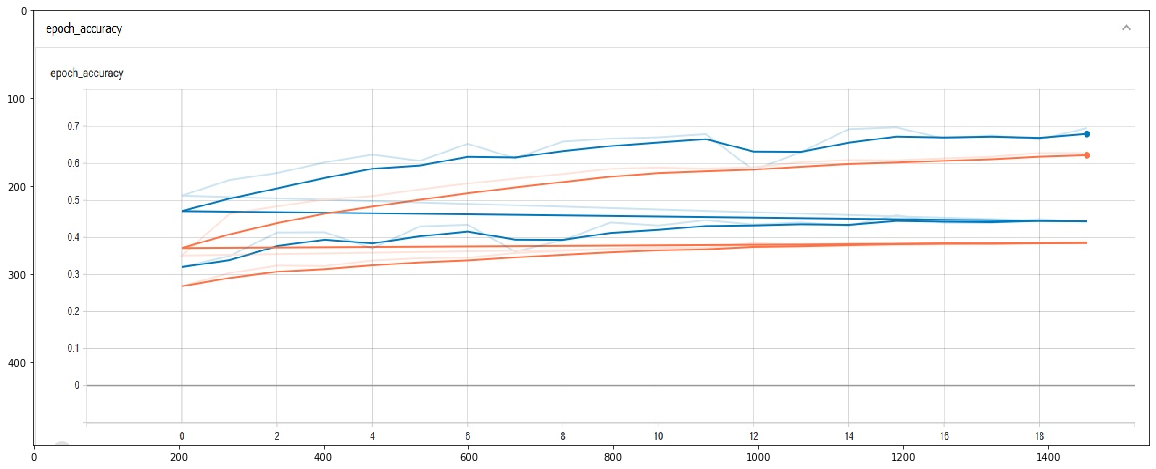

In [52]:
image = PIL.Image.open('assignment2.jpg')
plt.figure(figsize = (20,8))
plt.imshow(image, interpolation='nearest',aspect='auto')



I forgot to save the logs from the MLP and CNN with different names and I ended up with a line linking them, but the curves below display the MLP validation and training accuracies and above you can see the same for the CNN. As we can above just by switiching to a CNN while keeping the same architecture had an improvement of 26% in the validation accuracy.
FYI since I am running this locally due to connection limitations and it took hours to train the models and considering the deadline is today I will not redo this.

Furthermore due to time restrictions I have introduced regularization and dropout from the start and thus I did not compare the performance without these optimization techniques.

In [56]:
#predictions

preds = model.predict(test_generator)
#using softmax activation on output layer
predicted_labels  = np.argmax(preds,axis=1)



In [59]:
class_names = ['elefante','farfalla','mucca','pecora','scoiattolo']

In [60]:
#Accessing classnames with predicted clases
final_predictions = [class_names[i] for i in predicted_labels]

In [61]:
final_predictions[0]

'scoiattolo'

In [63]:
for i in range (0,len(testing_animals)):
    testing_animals.target[i] = final_predictions[i] 


testing_animals.head()

<ipython-input-63-7bf1f60f60b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_animals.target[i] = final_predictions[i]
c:\users\ricardo_2\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,filename,target
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,scoiattolo
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,farfalla
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,mucca
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,scoiattolo
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,mucca


In [65]:
testing_animals.to_csv('predictions.csv',index=False)